In [1]:
import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numba import jit
from scipy import optimize

In [2]:
funcs = {"sphere": 0, "schwefel": 1, "rosenbrock": 2, "rastrigin": 3, "griewank": 4, "ackley": 5}
funcs_dispname = {"sphere": "F1 : Shifted Sphere Function", 
                  "schwefel": "F2 : Schwefel’s Problem 2.21",
                  "rosenbrock": "F3 : Shifted Rosenbrock’s Function",
                  "rastrigin": "F4 : Shifted Rastrigin’s Function",
                  "griewank": "F5 : Shifted Griewank’s Function",
                  "ackley": "F6 : Shifted Ackley’s Function"}

In [3]:
def read_values(func):
    val_path = os.path.join('../data/', func_name + '.csv')
    bias_path = '../data/f_bias.csv'
    ss_path = '../data/search_space.csv'
    
    func_df = pd.read_csv(val_path)
    bias_df = pd.read_csv(bias_path)
    searchspace_df = pd.read_csv(ss_path)

    funcval = func_df.fvalue.values
    funcbias = bias_df.fvalue.values[funcs[func_name]]
    search_space = list(searchspace_df.iloc[funcs[func_name],])
    return funcval, funcbias, search_space

In [4]:
# function evaluation definitions

@jit(nopython=True)
def eval_fitness(x, dim):
    
    if func_name == "sphere":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z * z
        result = F + funcbias
    elif func_name == "schwefel":
        F = abs(x[0]- funcval[0])
        for i in range(1,dim - 1):
            z = x[i] - funcval[i]
            F = max(F, abs(z))
        result = F + funcbias
    elif func_name == "rosenbrock":
        F = 0
        y = np.empty(dim)
        for i in range(dim - 1):
            y[i] = x[i] - funcval[i] +1
        for i in range(dim-2):
            F += 100 * ((y[i]**2-y[i+1])**2) + (y[i]-1)**2
        result = F + funcbias
    elif func_name == "rastrigin":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 - 10 * math.cos(2 * math.pi * z) + 10
        result = F + funcbias
        
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += math.cos(z / math.sqrt(i + 1))
        result = F1 - F2 + 1 + funcbias
    elif func_name == "ackley":
        Sum1 = 0
        Sum2 = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            Sum1 += z ** 2
            Sum2 += math.cos(2 * math.pi * z)
        result = -20 * math.exp(-0.2 * math.sqrt(Sum1 / dim)) - math.exp(Sum2 / dim) + 20 + math.e + funcbias
    else:
        result = 0
    
    return result

In [5]:
def f(x, dim):
    result = eval_fitness(x, dim)
    fitness_per_eval.append(result)
    return result

In [6]:
def initial_solution(dim, bounds):
    xmin, xmax = bounds
    x_min = xmin * np.ones(dim)
    x_max = xmax * np.ones(dim)
    cur_x = np.random.uniform(min(x_min), max(x_max), (1, dim))
    return cur_x 

In [7]:
def optimize_minimize(dim, search_space, method, options):
    
    cur_x = initial_solution(dim, search_space)
    t1 = time.time()
    result = optimize.minimize(f, args=(dim), x0=cur_x, method=method, options=options)
    t2 = time.time()
    
    return result, t2-t1, fitness_per_eval

In [8]:
# function to make print report of function solving

def print_solution(dimension, method, options, result, log, duration):
    
    algorithm_name = method
    parameters = options
    solution_x = result.x
    fitness = log[-1]-funcbias
    n_evals = len(log)
    niter = result.nit
    print('-'*60)
    print("Function: %s" % funcs_dispname[func_name])
    print("Problem dimension: %d" % dimension)
    print("Search Space: ", search_space)
    print("Global Optimum: %.2f\n" % funcbias)
    print('-'*60)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters: \n%s" % parameters)
    print('-'*60)
    print("Fitness: %f" % fitness)
    print("Solution: ")
    with pd.option_context('display.max_rows',10):
        print(pd.DataFrame(solution_x, columns=['X']))
    print('-'*60)
    print("Nb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: gtol achieved: %.2e" % options['gtol'])
    print(result.message)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log-funcbias)
    plt.xlabel("iterations")
    plt.ylabel("fitness: f(x)-f(x*)")
    plt.show()

In [9]:
# select function of problem to be solved

# function to choose: sphere, schwefel, rosenbrock, rastrigin, griewank, ackley
func_name = 'sphere'
funcval, funcbias, search_space = read_values(func_name)

In [10]:
# define algorithm and parameters to use

method = 'BFGS'
options = {'maxiter': 100, 'gtol': 1e-5, 'disp': False}

------------------------------------------------------------
Function: F1 : Shifted Sphere Function
Problem dimension: 50
Search Space:  [-100, 100]
Global Optimum: -450.00

------------------------------------------------------------
Algorithm: BFGS
Parameters: 
{'maxiter': 100, 'gtol': 1e-05, 'disp': False}
------------------------------------------------------------
Fitness: 0.000000
Solution: 
            X
0   97.249936
1   77.060986
2  -19.031149
3   25.428700
4  -22.908802
..        ...
45 -24.766487
46  90.441367
47  43.864103
48  55.868490
49  19.270444

[50 rows x 1 columns]
------------------------------------------------------------
Nb of functions evaluations: 520
Stopping criterion: gtol achieved: 1.00e-05
Optimization terminated successfully.
computational time: 0.599 seconds


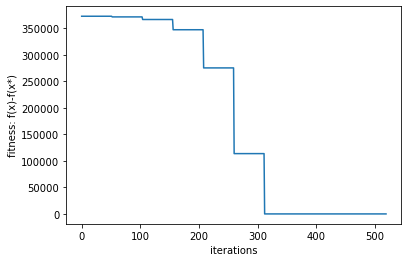

In [11]:
# run algorithm and print solution
DIM = 50
fitness_per_eval = []

result, duration, logs = optimize_minimize(DIM, search_space, method, options)
print_solution(dimension=DIM, method=method, options=options, result=result, log=logs, duration=duration)